In [1]:
# Librerías estándar
import pandas as pd
import numpy as np
import folium

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Modelado
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import joblib

In [2]:
# Funciones
def plot_target_distribution_continuous(df, target, bins=30, kde=True, color="skyblue"):
    """
    Grafica la distribución de una variable continua con histograma y KDE opcional.
    """
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=target, bins=bins, kde=kde, color=color)
    plt.title(f"Distribución de la variable continua: {target}")
    plt.xlabel(target)
    plt.ylabel("Frecuencia")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

def get_features_num_regression(df, target_col, umbral_corr=0.1, pvalue=None, mostrar=False):
    """
    Devuelve las variables numéricas más correlacionadas con una variable target continua.
    """
    if target_col not in df.columns:
        raise ValueError(f"Columna target {target_col} no está en el DataFrame.")
    if not isinstance(df, pd.DataFrame):
        raise TypeError("El dato de entrada tiene que ser un DataFrame.")
    if not np.issubdtype(df[target_col].dtype, np.number):
        raise TypeError(f"Columna target {target_col} tiene que ser numérica.")
    if df[target_col].isnull().sum() > 0:
        raise ValueError(f"Columna target {target_col} tiene valores nulos.")

    corr = df.corr(numeric_only=True)[target_col]
    corr = corr[abs(corr) > umbral_corr].drop(target_col)

    lista = []
    if pvalue is not None:
        for col in corr.index:
            _, p = pearsonr(df[target_col], df[col])
            if p < pvalue:
                lista.append(col)
    else:
        lista = corr.index.tolist()

    if mostrar:
        plt.figure(figsize=(10, 6))
        sns.heatmap(df[lista + [target_col]].corr(), annot=True, cmap='coolwarm', center=0)
        plt.title(f"Correlation heatmap for {target_col}")
        plt.show()

    return lista

def descripcion_variables(df):
    """
    Muestra una descripción textual de las variables de un DataFrame,
    clasificándolas como binarias, categóricas, discretas o continuas.
    """
    for col in df.columns:
        print(f"\n🔹 Variable: {col}")
        tipo = df[col].dtype
        print(f"Tipo: {tipo}")

        n_unicos = df[col].nunique()
        valores_unicos = df[col].dropna().unique()

        if n_unicos == 2:
            print("Tipo inferido: Binaria")
            modo = df[col].mode().iloc[0]
            frecuencia = df[col].value_counts().iloc[0]
            print(f"Más frecuente: {modo} ({frecuencia} veces)")

        elif tipo == "object":
            print("Tipo inferido: Categórica")
            print(f"Valores únicos: {n_unicos}")
            print(f"Más frecuente: {df[col].mode().iloc[0]} ({df[col].value_counts().iloc[0]} veces)")

        elif pd.api.types.is_integer_dtype(df[col]) and n_unicos <= 10:
            print("Tipo inferido: Discreta (recuento entero con pocos valores únicos)")
            print(f"Valores únicos: {n_unicos}")
            print(f"Más frecuente: {df[col].mode().iloc[0]} ({df[col].value_counts().iloc[0]} veces)")

        elif pd.api.types.is_numeric_dtype(df[col]):
            print("Tipo inferido: Numérica continua")
            print(f"Media: {df[col].mean():.2f}")
            print(f"Desviación estándar: {df[col].std():.2f}")
            print(f"Mínimo: {df[col].min()}")
            print(f"Máximo: {df[col].max()}")

        else:
            print("Tipo no identificado con claridad.")

def get_features_cat_regression(df, target_col, pvalue=0.05):
    from scipy.stats import f_oneway, ttest_ind

    relacionadas = []
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    for col in cat_cols:
        niveles = df[col].dropna().unique()
        grupos = [df[df[col] == nivel][target_col].dropna() for nivel in niveles]

        if any(len(grupo) < 2 for grupo in grupos):
            continue

        try:
            if len(niveles) == 2:
                stat, p = ttest_ind(*grupos)
            elif len(niveles) > 2:
                stat, p = f_oneway(*grupos)
            else:
                continue

            if p < pvalue:
                relacionadas.append(col)
        except Exception as e:
            continue
    return relacionadas

def plot_predictions_vs_actual(y_real, y_pred):
    """
    Gráfico de valores reales vs predichos en problemas de regresión.
    """
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, y_real, alpha=0.5)
    plt.xlabel("Valores Predichos")
    plt.ylabel("Valores Reales")

    max_value = max(max(y_real), max(y_pred))
    min_value = min(min(y_real), min(y_pred))
    plt.plot([min_value, max_value], [min_value, max_value], 'r')

    plt.title("Comparación de Valores Reales vs. Predichos")
    plt.show()


In [3]:
# Cargar el archivo
df = pd.read_csv("listings.csv", low_memory=False)

# Ver tamaño y primeras columnas
print(df.shape)
df.head()

(19422, 18)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,18674,Huge flat for 8 people close to Sagrada Familia,71615,Mireia Maria,Eixample,la Sagrada Família,41.405560,2.17262,Entire home/apt,179.0,1,45,2024-09-16,0.31,29,147,5,HUTB-002062
1,23197,"Forum CCIB DeLuxe, Spacious, Large Balcony, relax",90417,Etain (Marnie),Sant Martí,el Besòs i el Maresme,41.412432,2.21975,Entire home/apt,251.0,3,82,2025-01-03,0.48,1,0,8,HUTB005057
2,32711,Sagrada Familia area - Còrsega 1,135703,Nick,Gràcia,el Camp d'en Grassot i Gràcia Nova,41.405660,2.17015,Entire home/apt,104.0,1,143,2025-03-04,0.86,3,107,31,HUTB-001722
3,34241,Stylish Top Floor Apartment - Ramblas Plaza Real,73163,Andres,Ciutat Vella,el Barri Gòtic,41.380620,2.17517,Entire home/apt,157.0,31,25,2024-11-05,0.14,3,327,15,Exempt
4,34981,VIDRE HOME PLAZA REAL on LAS RAMBLAS,73163,Andres,Ciutat Vella,el Barri Gòtic,41.379780,2.17623,Entire home/apt,401.0,5,256,2025-02-02,1.46,3,191,34,HUTB-150671


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19422 entries, 0 to 19421
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              19422 non-null  int64  
 1   name                            19422 non-null  object 
 2   host_id                         19422 non-null  int64  
 3   host_name                       19415 non-null  object 
 4   neighbourhood_group             19422 non-null  object 
 5   neighbourhood                   19422 non-null  object 
 6   latitude                        19422 non-null  float64
 7   longitude                       19422 non-null  float64
 8   room_type                       19422 non-null  object 
 9   price                           15273 non-null  float64
 10  minimum_nights                  19422 non-null  int64  
 11  number_of_reviews               19422 non-null  int64  
 12  last_review                     

In [5]:
descripcion_variables(df)


🔹 Variable: id
Tipo: int64
Tipo inferido: Numérica continua
Media: 534073498110556032.00
Desviación estándar: 538654143508630080.00
Mínimo: 18674
Máximo: 1368965855500703159

🔹 Variable: name
Tipo: object
Tipo inferido: Categórica
Valores únicos: 18639
Más frecuente: Double or Twin Room (12 veces)

🔹 Variable: host_id
Tipo: int64
Tipo inferido: Numérica continua
Media: 201109861.29
Desviación estándar: 203345333.68
Mínimo: 3073
Máximo: 680169713

🔹 Variable: host_name
Tipo: object
Tipo inferido: Categórica
Valores únicos: 3349
Más frecuente: Ukio (483 veces)

🔹 Variable: neighbourhood_group
Tipo: object
Tipo inferido: Categórica
Valores únicos: 10
Más frecuente: Eixample (6955 veces)

🔹 Variable: neighbourhood
Tipo: object
Tipo inferido: Categórica
Valores únicos: 71
Más frecuente: la Dreta de l'Eixample (2393 veces)

🔹 Variable: latitude
Tipo: float64
Tipo inferido: Numérica continua
Media: 41.39
Desviación estándar: 0.01
Mínimo: 41.33531017971992
Máximo: 41.4563771

🔹 Variable: long

In [6]:
# Copia de columnas relevantes
cols = [
    'id', 'name', 'neighbourhood', 'latitude', 'longitude',
    'room_type', 'price', 'minimum_nights', 'availability_365',
    'number_of_reviews', 'reviews_per_month'
]

df = df[cols].copy()

# Eliminar filas sin precio
df.dropna(subset=['price'], inplace=True)

# Eliminar alojamientos con precio 0 o negativo
df = df[df['price'] > 0]

# Poner columna 'id' como índice
df.set_index('id', inplace=True)

# Eliminar columna 'name' innecesaria
df.drop(columns=['name'], inplace=True)

# Mostrar resultado
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 15273 entries, 18674 to 1366501139971684620
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   neighbourhood      15273 non-null  object 
 1   latitude           15273 non-null  float64
 2   longitude          15273 non-null  float64
 3   room_type          15273 non-null  object 
 4   price              15273 non-null  float64
 5   minimum_nights     15273 non-null  int64  
 6   availability_365   15273 non-null  int64  
 7   number_of_reviews  15273 non-null  int64  
 8   reviews_per_month  11868 non-null  float64
dtypes: float64(4), int64(3), object(2)
memory usage: 1.2+ MB


,neighbourhood,latitude,longitude,room_type,price,minimum_nights,availability_365,number_of_reviews,reviews_per_month
id,,,,,,,,,
18674,la Sagrada Família,41.405560,2.17262,Entire home/apt,179.0,1,147,45,0.31
23197,el Besòs i el Maresme,41.412432,2.21975,Entire home/apt,251.0,3,0,82,0.48
32711,el Camp d'en Grassot i Gràcia Nova,41.405660,2.17015,Entire home/apt,104.0,1,107,143,0.86
34241,el Barri Gòtic,41.380620,2.17517,Entire home/apt,157.0,31,327,25,0.14
34981,el Barri Gòtic,41.379780,2.17623,Entire home/apt,401.0,5,191,256,1.46


In [7]:
# Estadísticas generales
df.describe(include='all')

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,availability_365,number_of_reviews,reviews_per_month
count,15273,15273.000000,15273.000000,15273,15273.000000,15273.000000,15273.000000,15273.000000,11868.000000
unique,70,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN
top,la Dreta de l'Eixample,NaN,NaN,Entire home/apt,NaN,NaN,NaN,NaN,NaN
freq,1949,NaN,NaN,10438,NaN,NaN,NaN,NaN,NaN
mean,NaN,41.392092,2.166749,NaN,161.542264,14.754731,191.724219,57.948995,1.638309
std,NaN,0.013830,0.017669,NaN,327.006539,20.461723,120.589270,113.581184,2.111148
min,NaN,41.335310,2.085593,NaN,8.000000,1.000000,0.000000,0.000000,0.010000
25%,NaN,41.381158,2.156320,NaN,65.000000,1.000000,83.000000,1.000000,0.290000
50%,NaN,41.390155,2.167560,NaN,117.000000,3.000000,217.000000,9.000000,1.040000
75%,NaN,41.401530,2.177170,NaN,181.000000,31.000000,294.000000,65.000000,2.420000


Los nulos de "reviews_per_month" son alojamientos nuevos que aún no tienen reseñas, les añadimos el valor "0" para que no cuente como nulo.

In [8]:
# Rellenar valores nulos con 0 en reviews_per_month
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

# Comprobamos que ya no hay nulos
df['reviews_per_month'].isna().sum()

np.int64(0)

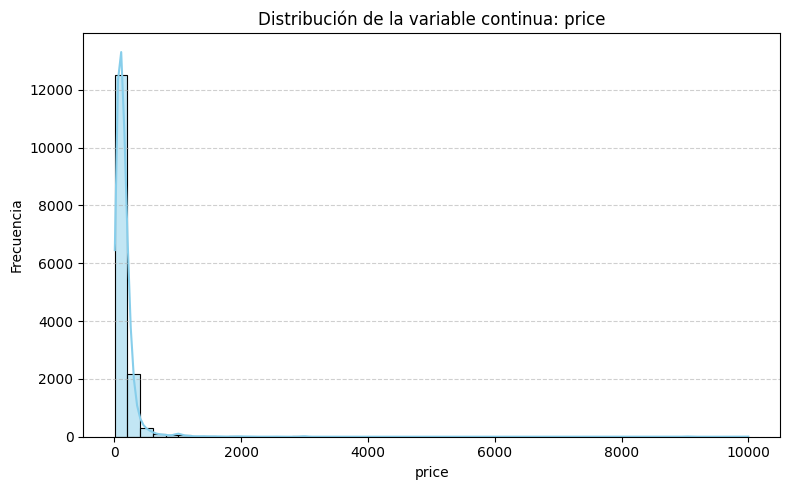

In [9]:
#2. MINI EDA
#2.1. Distribución de precios
# Histograma con KDE para la variable target 'price'
plot_target_distribution_continuous(df, target='price', bins=50, kde=True, color='skyblue')


Muy sesgada a la derecha, la mayoría de alojamientos tienen precios bajos, pero hay una cola larga con precios altísimos y outliers claros, valores que llegan hasta 10.000€ (pueden ser errores o alojamientos de lujo). Vamos a filtrar los outliers por encima de cierto umbral lógico y eliminar los precios superiores al percentil 99

In [10]:
umbral_price = df['price'].quantile(0.99)
df = df[df['price'] <= umbral_price]

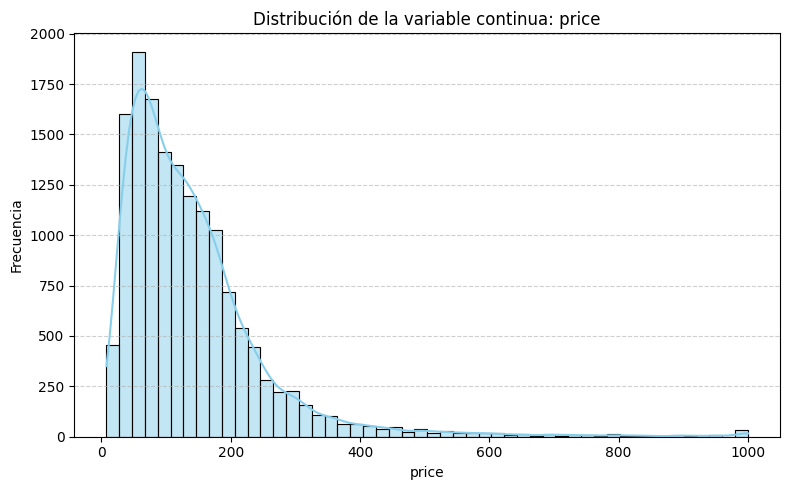

In [11]:
plot_target_distribution_continuous(df, target='price', bins=50, kde=True, color='skyblue')

Mayoría de precios entre 50€ y 250€, modelo más estable y preciso sin valores extremos.

In [12]:
#2.2. Distribución de minimum_nights
print(df['minimum_nights'].describe())

# Filtrado de valores extremos
umbral_nights = df['minimum_nights'].quantile(0.99)
df = df[df['minimum_nights'] <= umbral_nights]

count    15137.000000
mean        14.855520
std         20.469985
min          1.000000
25%          1.000000
50%          3.000000
75%         31.000000
max        865.000000
Name: minimum_nights, dtype: float64


El 75% de los alojamientos requieren hasta 1 mes (31 noches) como mínimo, pero hay valores extremos como 365, 800, 865... que seguramente son:

- Errores
- Alojamiento de larga estancia mal etiquetado
- Casos atípicos muy poco representativos

Vamos a filtrar valores extremos por encima del percentil 99.

In [13]:
umbral_nights = df['minimum_nights'].quantile(0.99)
df = df[df['minimum_nights'] <= umbral_nights]

In [14]:
print(df['minimum_nights'].describe())

count    14892.000000
mean        13.547744
std         14.441816
min          1.000000
25%          1.000000
50%          3.000000
75%         31.000000
max         35.000000
Name: minimum_nights, dtype: float64


Ahora el máximo es 35 noches, mucho más realista. Hemos perdido unas 380 filas, pero se mejora bastante el dataset y la robustez del modelo. 

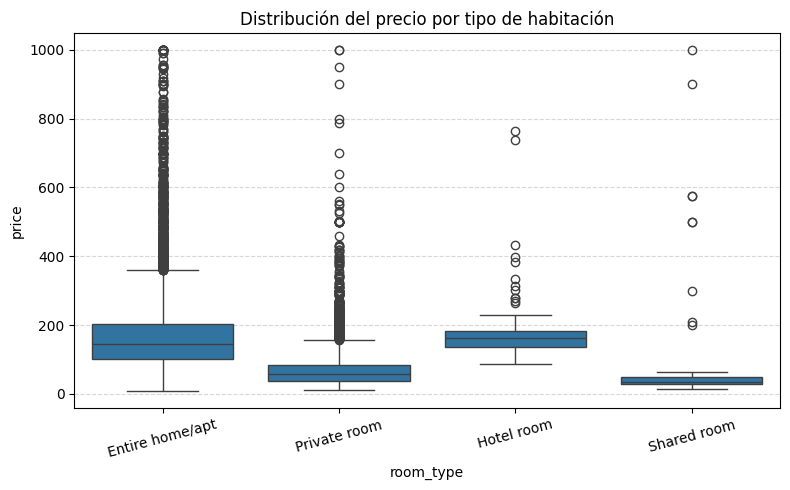

In [15]:
#2.3. Boxplot por tipo de habitación
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='room_type', y='price')
plt.title('Distribución del precio por tipo de habitación')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

"room_type" es una feature muy importante para predecir el precio → lo mantendremos.

El modelo debe capturar estas diferencias porque el tipo de habitación condiciona el rango completo de precios posibles.

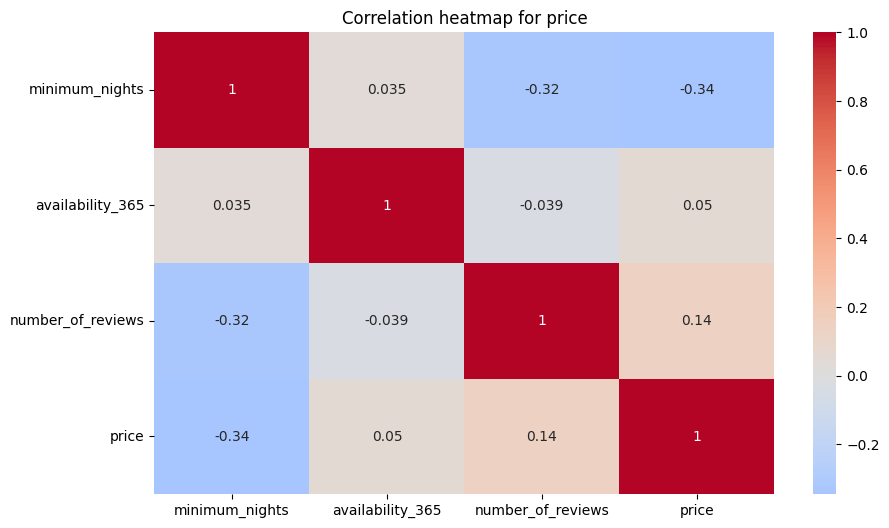

📌 Variables numéricas más correlacionadas con 'price':
['minimum_nights', 'availability_365', 'number_of_reviews']


In [16]:
#2.4. Variables correlacionadas con el precio
features_correladas = get_features_num_regression(
    df,
    target_col='price',
    umbral_corr=0.05,
    pvalue=0.05,
    mostrar=True
)

print("📌 Variables numéricas más correlacionadas con 'price':")
print(features_correladas)

Es una relación lógica en Airbnb: estancias largas suelen tener un precio reducido (descuento por semana o mes).

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14892 entries, 18674 to 1366501139971684620
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   neighbourhood      14892 non-null  object 
 1   latitude           14892 non-null  float64
 2   longitude          14892 non-null  float64
 3   room_type          14892 non-null  object 
 4   price              14892 non-null  float64
 5   minimum_nights     14892 non-null  int64  
 6   availability_365   14892 non-null  int64  
 7   number_of_reviews  14892 non-null  int64  
 8   reviews_per_month  14892 non-null  float64
dtypes: float64(4), int64(3), object(2)
memory usage: 1.1+ MB


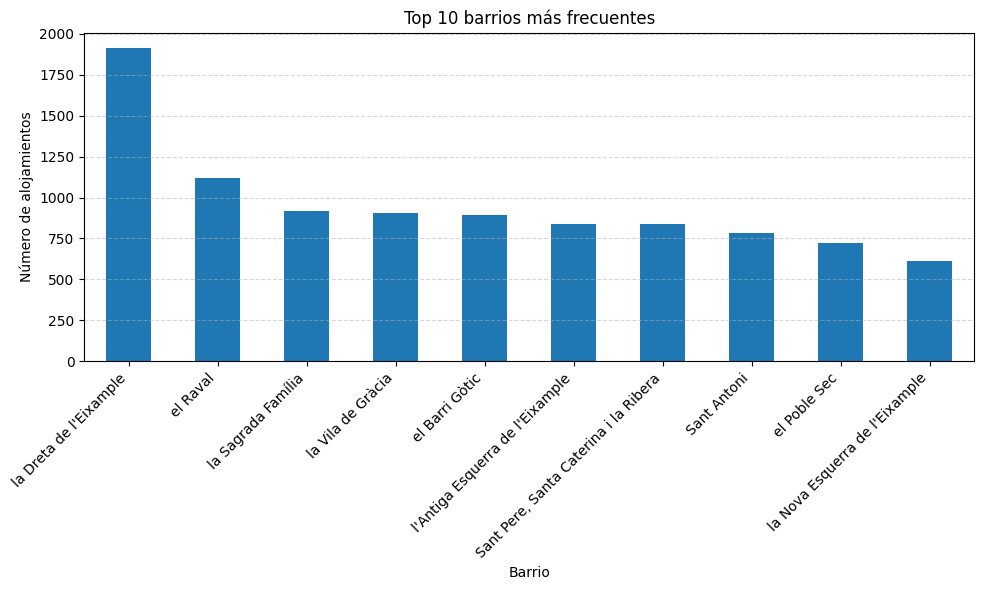

In [18]:
# Visualizamos frecuencia de "neighbourhood"
plt.figure(figsize=(10,6))
df['neighbourhood'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 barrios más frecuentes")
plt.xlabel("Barrio")
plt.ylabel("Número de alojamientos")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [19]:
# ¿Influye el barrio en el precio?
get_features_cat_regression(df, target_col='price')

['room_type']

Aunque get_features_cat_regression no detectó "neighbourhood" como estadísticamente significativa, en la práctica sí lo es, y debería formar parte de las features del modelo.

Esto ocurre porque:

- El test ANOVA puede fallar con demasiados grupos.
- El modelo ML (Random Forest, XGBoost…) sí puede capturar esas diferencias.

In [20]:
# Revisamos la media de price por barrio
df.groupby('neighbourhood')['price'].mean().sort_values(ascending=False).head(10)

neighbourhood
la Vila Olímpica del Poblenou                   229.305556
Diagonal Mar i el Front Marítim del Poblenou    224.161765
la Dreta de l'Eixample                          192.346073
el Fort Pienc                                   172.400498
el Coll                                         171.583333
la Sagrada Família                              170.744565
Sant Antoni                                     160.351592
l'Antiga Esquerra de l'Eixample                 159.417360
Can Baró                                        152.666667
Canyelles                                       147.000000
Name: price, dtype: float64

In [21]:
# One-hot encoding para variables categóricas
# Codificar room_type y neighbourhood (con pandas)
df = pd.get_dummies(df, columns=['room_type', 'neighbourhood'], drop_first=True)

In [22]:
df.head()

,latitude,longitude,price,minimum_nights,availability_365,number_of_reviews,reviews_per_month,room_type_Hotel room,room_type_Private room,room_type_Shared room,...,neighbourhood_la Teixonera,neighbourhood_la Trinitat Nova,neighbourhood_la Trinitat Vella,neighbourhood_la Vall d'Hebron,neighbourhood_la Verneda i la Pau,neighbourhood_la Vila Olímpica del Poblenou,neighbourhood_la Vila de Gràcia,neighbourhood_les Corts,neighbourhood_les Roquetes,neighbourhood_les Tres Torres
id,,,,,,,,,,,,,,,,,,,,,
18674,41.405560,2.17262,179.0,1,147,45,0.31,False,False,False,...,False,False,False,False,False,False,False,False,False,False
23197,41.412432,2.21975,251.0,3,0,82,0.48,False,False,False,...,False,False,False,False,False,False,False,False,False,False
32711,41.405660,2.17015,104.0,1,107,143,0.86,False,False,False,...,False,False,False,False,False,False,False,False,False,False
34241,41.380620,2.17517,157.0,31,327,25,0.14,False,False,False,...,False,False,False,False,False,False,False,False,False,False
34981,41.379780,2.17623,401.0,5,191,256,1.46,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [23]:
df.info

<bound method DataFrame.info of                       latitude  longitude  price  minimum_nights  \
id                                                                 
18674                41.405560   2.172620  179.0               1   
23197                41.412432   2.219750  251.0               3   
32711                41.405660   2.170150  104.0               1   
34241                41.380620   2.175170  157.0              31   
34981                41.379780   2.176230  401.0               5   
...                        ...        ...    ...             ...   
1366108822123777508  41.399074   2.159820   27.0              31   
1366453124999573764  41.391440   2.176490   60.0               1   
1366459989694212599  41.371550   2.159870  103.0              33   
1366500461965716620  41.392220   2.168250   31.0              32   
1366501139971684620  41.404897   2.180792  307.0               2   

                     availability_365  number_of_reviews  reviews_per_month  \
id  

In [24]:
# Seleccionamos features y target
# Definir X e y
X = df.drop(columns=['price'])  # Variables predictoras
y = df['price']                 # Variable objetivo

In [25]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size= 0.2, random_state= 42)

In [26]:
corr = train_set.corr(numeric_only = True)

In [27]:
target = df['price']

In [28]:
correlaciones = df.corr(numeric_only=True)['price'].sort_values(ascending=False)
correlaciones = correlaciones.reset_index()
correlaciones.columns = ['feature', 'correlacion_con_price']
pd.set_option('display.max_rows', None)
display(correlaciones)

,feature,correlacion_con_price
0,price,1.000000
1,neighbourhood_la Dreta de l'Eixample,0.166189
2,number_of_reviews,0.135385
3,neighbourhood_Diagonal Mar i el Front Marítim ...,0.067873
4,neighbourhood_la Vila Olímpica del Poblenou,0.064209
5,neighbourhood_la Sagrada Família,0.063490
6,availability_365,0.050455
7,reviews_per_month,0.043979
8,neighbourhood_el Fort Pienc,0.043584
9,neighbourhood_Sant Antoni,0.037273


In [29]:
features = df.drop(columns=['price'])

In [30]:
# División train-test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [31]:
# Entrenamiento con RandomForestRegressor
# Entrenar modelo base
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [32]:
# Predicciones y métricas
# Predicciones
y_pred = model_rf.predict(X_test)

# Métricas
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

print("MAE:", mean_absolute_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 50.13017180462248
RMSE: 90.47
R²: 0.4022


El error promedio por predicción es de unos 50€.

El RMSE de ~90 € indica que el modelo se equivoca en promedio unos 90 € por predicción. Teniendo en cuenta que muchos precios están entre 50 € y 300 €, no está mal pero hay margen de mejora.

El R² de 0.40 significa que el modelo explica el 40% de la variabilidad del precio. No es espectacular, pero es un buen punto de partida.

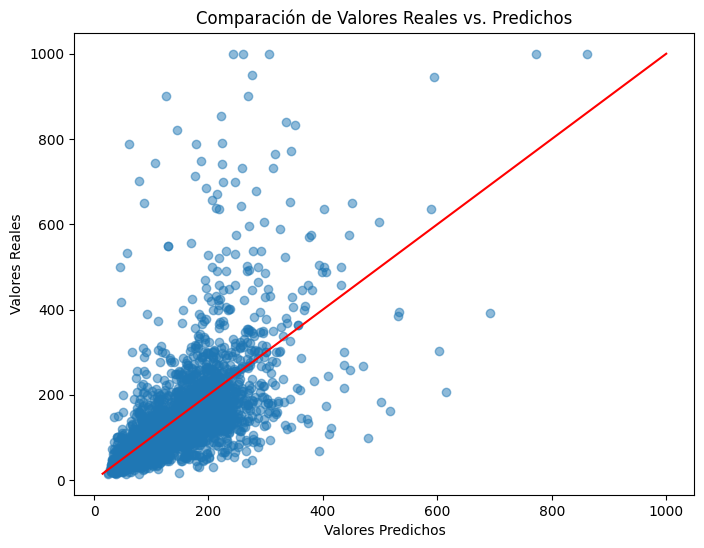

In [33]:
# Visualización: Reales vs Predichos
plot_predictions_vs_actual(y_test, y_pred)

✅ Cosas buenas:
- El modelo captura bien la tendencia general (más caro ↔ más predicho).
- La mayoría de los puntos están cerca de la diagonal, especialmente para precios bajos y medios.

⚠️ Cosas mejorables:
- A partir de los 300–400 €, el modelo empieza a subestimar muchos precios (se quedan por debajo de la línea roja).

- También hay cierta dispersión: algunos valores reales son muy altos pero el modelo los predice mucho más bajos → esto podría perjudicar la detección de infravalorados si no se ajusta.

In [34]:
# Entrenamiento base con XGBoost
model_xgb = XGBRegressor(n_estimators=200, learning_rate=0.1,max_depth=6, random_state=42)
model_xgb.fit(X_train, y_train)

# Predicción
y_pred_xgb = model_xgb.predict(X_test)

# Evaluación
rmse_xgb = mean_squared_error(y_test, y_pred_xgb) ** 0.5
r2_xgb = r2_score(y_test, y_pred_xgb)

print("MAE XGB:", mean_absolute_error(y_test, y_pred_xgb))
print(f"📊 RMSE XGBoost: {rmse_xgb:.2f}")
print(f"📈 R² XGBoost: {r2_xgb:.4f}")

MAE XGB: 52.97575658661842
📊 RMSE XGBoost: 92.20
📈 R² XGBoost: 0.3791


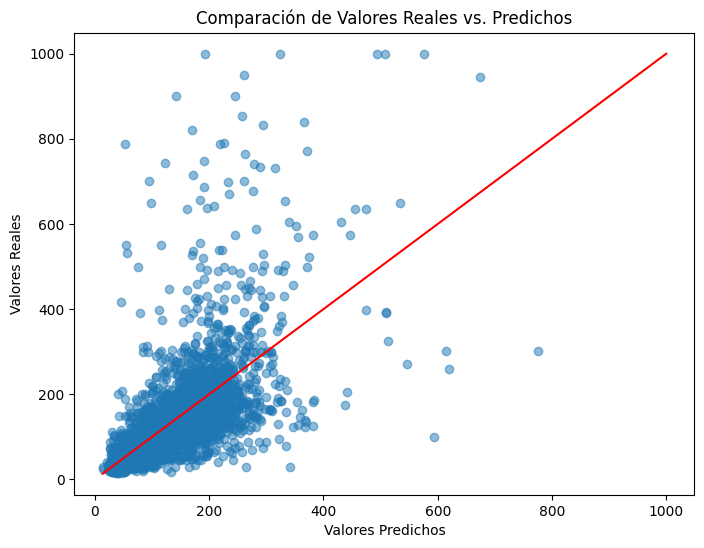

In [35]:
plot_predictions_vs_actual(y_test, y_pred_xgb)

📉 XGBoost ha rendido ligeramente peor en ambos indicadores.

📈 Visualmente también parece infrapredecir más en precios altos, como pasaba con RF pero algo más acusado.

🔹 Random Forest sigue siendo el mejor modelo por ahora, aunque aún hay que optimizarlo

In [36]:
# Definimos la malla de hiperparámetros
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Instanciamos el modelo base
rf_base = RandomForestRegressor(random_state=42)

# Configuramos GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

# Entrenamos
grid_search.fit(X_train, y_train)

# Guardamos el mejor modelo
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [37]:
# Evaluación del mejor modelo

# Predicciones
y_pred_rf = best_rf.predict(X_test)

# Métricas
rmse_rf = mean_squared_error(y_test, y_pred_rf) ** 0.5
r2_rf = r2_score(y_test, y_pred_rf)

print("🔧 Mejor combinación de hiperparámetros:")
print(grid_search.best_params_)
print("📉 MAE:", mean_absolute_error(y_test, y_pred_rf))
print(f"📊 RMSE optimizado: {rmse_rf:.2f}")
print(f"📈 R² optimizado: {r2_rf:.4f}")


🔧 Mejor combinación de hiperparámetros:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
📉 MAE: 48.94632226323624
📊 RMSE optimizado: 87.69
📈 R² optimizado: 0.4383


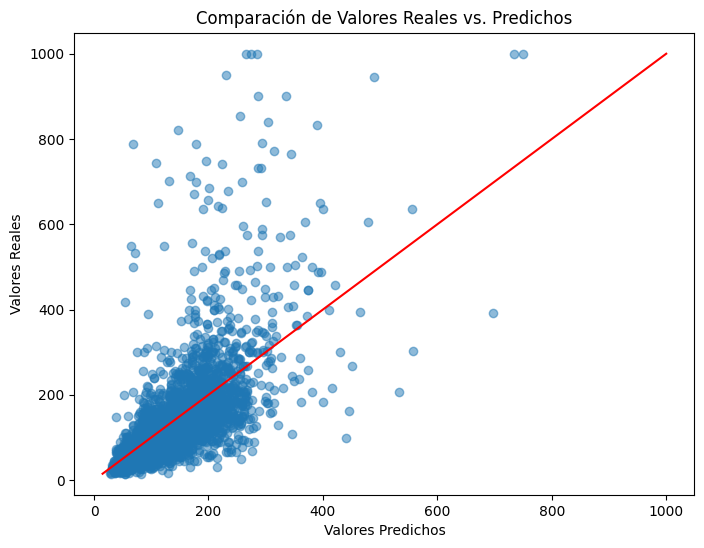

In [38]:
plot_predictions_vs_actual(y_test, y_pred_rf)

Hemos reducido el error en casi 3€ por predicción y la capacidad explicativa en casi 4 puntos de R². Vamos a intentar mejorarlo aún mas.

In [39]:
# Ampliamos el espacio de búsqueda del GridSearch (más combinaciones)
# Definimos la malla de hiperparámetros
param_grid_amplio = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Instanciamos el modelo base
rf_base = RandomForestRegressor(random_state=42)

# Configuramos GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Entrenamos
grid_search.fit(X_train, y_train)

# Guardamos el mejor modelo
best_rf = grid_search.best_estimator_

Fitting 3 folds for each of 48 candidates, totalling 144 fits


In [40]:
# Evaluación del mejor modelo

# Predicciones
y_pred_rf = best_rf.predict(X_test)

# Métricas
rmse_rf = mean_squared_error(y_test, y_pred_rf) ** 0.5
r2_rf = r2_score(y_test, y_pred_rf)

print("🔧 Mejor combinación de hiperparámetros:")
print(grid_search.best_params_)
print("📉 MAE:", mean_absolute_error(y_test, y_pred_rf))
print(f"📊 RMSE optimizado: {rmse_rf:.2f}")
print(f"📈 R² optimizado: {r2_rf:.4f}")

🔧 Mejor combinación de hiperparámetros:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
📉 MAE: 48.98086051065716
📊 RMSE optimizado: 87.69
📈 R² optimizado: 0.4384


In [41]:
from scipy.stats import randint
# Cambiamos a RandomizedSearchCV para ver si mejora
# Espacio de búsqueda más amplio
param_dist = {
    'n_estimators': randint(100, 400),
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,  # Número de combinaciones que probará
    scoring='neg_mean_absolute_error',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)
best_rf_random = random_search.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [42]:
# Evaluamos el mejor modelo obtenido
y_pred_best = best_rf.predict(X_test)

print("🎯 Mejor combinación:")
print(random_search.best_params_)
print("📉 MAE:", mean_absolute_error(y_test, y_pred_best))
print(f"📊 RMSE optimizado: {rmse_rf:.2f}")
print("📈 R²:", r2_score(y_test, y_pred_best))


🎯 Mejor combinación:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 154}
📉 MAE: 48.98086051065716
📊 RMSE optimizado: 87.69
📈 R²: 0.43835504022535077


Mejora algo, pero vamos a probar a transformar el target (price) con log1p

In [43]:
df['log_price'] = np.log1p(df['price'])  # log(1 + price) para evitar log(0)

In [44]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

rf.fit(X_train, y_train_log)
y_pred_log = rf.predict(X_test)

# Volvemos a escala original
y_pred = np.expm1(y_pred_log)

print("MAE:", mean_absolute_error(y_test, y_pred))
print(f"RMSE optimizado: {rmse_rf:.2f}")
print("R²:", r2_score(y_test, y_pred))


MAE: 46.748291654182665
RMSE optimizado: 87.69
R²: 0.4098170761954264


Esto indica que el modelo se ajusta mejor a los precios bajos y medios, aunque sacrifica un poco de R², lo cual es esperable porque ahora está penalizando menos los precios altos.

In [45]:
# Si ya existe una columna errónea, elimínala
if 'predicted_price' in df.columns:
    df.drop(columns=['predicted_price'], inplace=True)

# Volver a predecir correctamente desde el modelo
df['predicted_log'] = best_rf.predict(features)
df['predicted_price'] = np.expm1(df['predicted_log'])

c:\Users\sanlo\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [46]:
df['gap'] = df['predicted_price'] - df['price']
df['infravalorado'] = df['gap'] > 20

barrio_stats = df.groupby("neighbourhood_recover")[["price", "predicted_price"]].mean()
barrio_stats["gap_promedio"] = barrio_stats["predicted_price"] - barrio_stats["price"]
barrio_stats = barrio_stats.sort_values(by="gap_promedio", ascending=False)
display(barrio_stats.head(10))

KeyError: 'neighbourhood_recover'

In [ ]:
neigh_price = df.groupby('neighbourhood_recover')['price'].mean().rename('neighbourhood_avg_price')
df = df.merge(neigh_price, left_on='neighbourhood_recover', right_index=True, how='left')

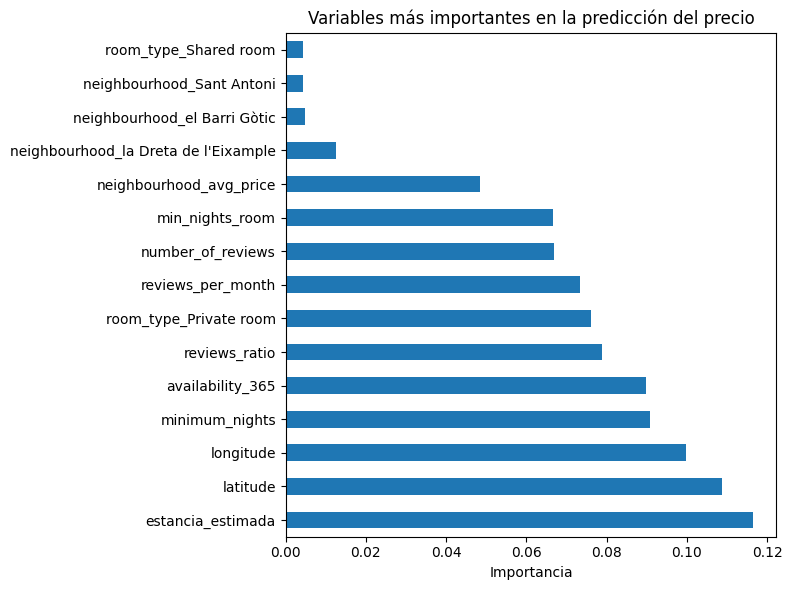

In [ ]:
# Obtener importancias
importancias = pd.Series(best_rf.feature_importances_, index=X_train.columns)

# Mostrar top 15
importancias.nlargest(15).plot(kind='barh', figsize=(8,6))
plt.title("Variables más importantes en la predicción del precio")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()

In [ ]:
# Detección de alojamientos infravalorados
# Generar predicciones para todo el dataset
df['predicted_price'] = best_rf.predict(df.drop(columns=['price']))

In [ ]:
# Calcular la diferencia entre precio predicho y real
df['gap'] = df['predicted_price'] - df['price']

In [ ]:
# Marcar si está infravalorado
umbral = 30
df['infravalorado'] = df['gap'] > umbral

In [ ]:
# Mostrar el top10 de chollos
top_chollos = df[df['infravalorado']].sort_values(by='gap', ascending=False).head(10)
top_chollos[['predicted_price', 'price', 'gap'] + [col for col in df.columns if col.startswith('neighbourhood_') or col.startswith('room_type_')]].head(10)

,predicted_price,price,gap,room_type_Hotel room,room_type_Private room,room_type_Shared room,neighbourhood_Can Peguera,neighbourhood_Canyelles,neighbourhood_Diagonal Mar i el Front Marítim del Poblenou,neighbourhood_Horta,...,neighbourhood_la Trinitat Nova,neighbourhood_la Trinitat Vella,neighbourhood_la Vall d'Hebron,neighbourhood_la Verneda i la Pau,neighbourhood_la Vila Olímpica del Poblenou,neighbourhood_la Vila de Gràcia,neighbourhood_les Corts,neighbourhood_les Roquetes,neighbourhood_les Tres Torres,neighbourhood_avg_price
9634,595.34,206.0,389.34,False,False,False,0,0,0,0,...,0,0,0,0,0,0,0,0,0,192.346073
12833,428.86,99.0,329.86,False,False,False,0,0,0,0,...,0,0,0,0,0,0,0,0,0,132.363636
10490,710.50,391.0,319.50,False,False,False,0,0,0,0,...,0,0,0,0,0,0,0,0,0,142.396748
10464,515.25,216.0,299.25,False,False,False,0,0,0,0,...,0,0,0,0,0,0,0,0,0,129.255034
10757,573.73,302.0,271.73,False,False,False,0,0,0,0,...,0,0,0,0,0,0,0,0,0,142.396748
10672,296.06,52.0,244.06,False,True,False,0,0,0,0,...,0,0,0,0,0,0,0,0,0,159.417360
15069,393.95,162.0,231.95,False,False,False,0,0,1,0,...,0,0,0,0,0,0,0,0,0,224.161765
14096,325.32,108.0,217.32,False,False,False,0,0,0,0,...,0,0,0,0,0,0,0,0,0,160.351592
8573,300.40,89.0,211.40,False,False,False,0,0,0,0,...,0,0,0,0,0,0,0,0,0,172.400498
1962,276.95,69.0,207.95,False,False,False,0,0,0,0,...,0,0,0,0,0,0,0,0,0,192.346073


In [ ]:
from folium.plugins import MarkerCluster

# Crear el mapa centrado en Barcelona
mapa_barcelona = folium.Map(location=[41.3851, 2.1734], zoom_start=12)

# Crear el clúster de marcadores
cluster = MarkerCluster().add_to(mapa_barcelona)

# Seleccionar el top 50 de alojamientos con mayor diferencia (gap más alto)
top_chollos = df[df['infravalorado']].sort_values(by='gap', ascending=False).head(50)

# Añadir marcadores al clúster
for _, row in top_chollos.iterrows():
    popup_text = (
        f"<b>Precio real:</b> {row['price']} €<br>"
        f"<b>Precio estimado:</b> {row['predicted_price']:.2f} €<br>"
        f"<b>Diferencia:</b> {row['gap']:.2f} €"
    )
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=folium.Popup(popup_text, max_width=300),
        icon=folium.Icon(color='green', icon='euro-sign', prefix='fa')
    ).add_to(cluster)

# Mostrar el mapa en notebook
mapa_barcelona